# Naive Bayes Classification Model

In [36]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
# Reading in data
df = pd.read_csv('./data/processed_posts.csv',index_col=0 )

In [26]:
# Creating X and y
X = df['lem_all_text']
y = df['subreddit']

## Naive-Bayes Basic Estimator

In [27]:
# Potential stop words to use in my model
my_stop_words = text.ENGLISH_STOP_WORDS.union(["removed", 'data', 'http', 'machine', 'learning',
                                               'ai', 'artificial', 'intelligence', 'removed', 'com'])

I attempted to remove some words that appeared frequently in both subreddits. Removing these terms hurt model performance. I am leaving these words in the training data to keep the performance level high.

In [28]:
# Tried both CountVectorizer and TfidfVectorizer. 
# Acheived slightly better results with TfidfVectorizer
tvect = TfidfVectorizer(stop_words = 'english')

In [29]:
X_tvect = tvect.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_tvect, y, stratify=y)

In [31]:
# Setting alpha to 250 based on results from grid search below
nb = MultinomialNB(alpha=250)

In [32]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=250)

In [33]:
test_preds = nb.predict(X_test)
train_preds = nb.predict(X_train)

In [34]:
print(f' Training Accuracy: {nb.score(X_train, y_train)}')
print(f' Test Accuracy: {nb.score(X_test, y_test)}')
print(f' Training f1: {f1_score(y_train, train_preds)}')
print(f' Test f1: {f1_score(y_test, test_preds)}')

 Training Accuracy: 0.8320837554880108
 Test Accuracy: 0.8255672609400324
 Training f1: 0.8351896048793422
 Test f1: 0.827903258045173


In [38]:
!pwd

/Users/alexander.fioto/dsir-824/submissions/projects/project-3-master


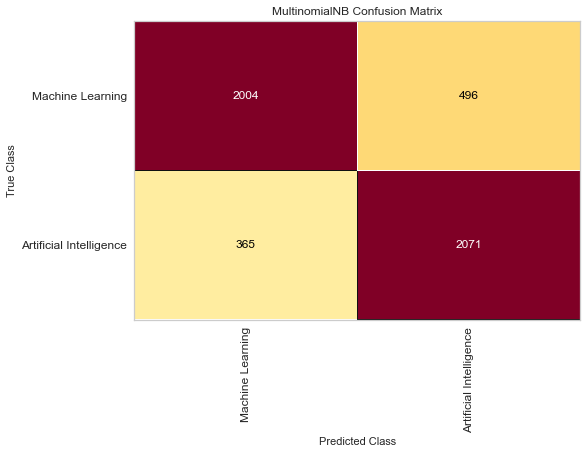

In [57]:
# We gather from the confusion matrix that we predicting more subreddits as AI when they are in fact ML 
cm = ConfusionMatrix(nb, classes=['Machine Learning', 'Artificial Intelligence'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show(outpath='./assets/nb_cm.png');



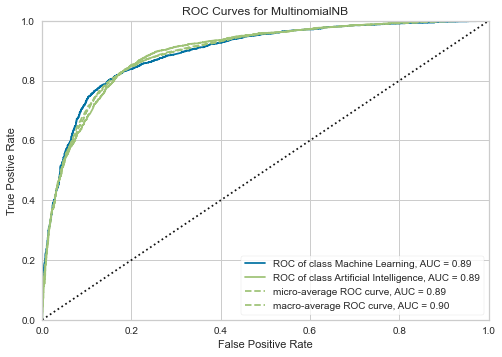

In [40]:
# Visualizing the ROC AUC
rocauc_viz = ROCAUC(nb, classes=['Machine Learning', 'Artificial Intelligence'])
rocauc_viz.fit(X_train, y_train)
rocauc_viz.score(X_test, y_test)
rocauc_viz.show(outpath='./assets/nb_rocauc.png');

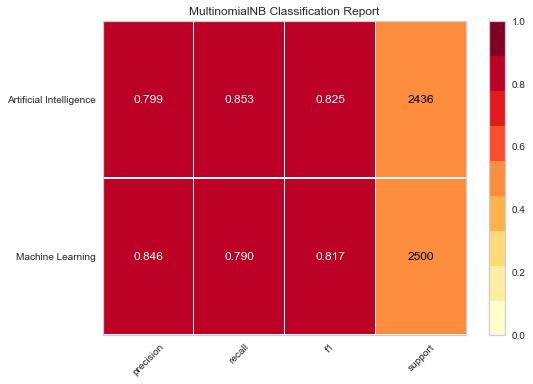

In [18]:
# Inspecting classification metrics on a class basis.
visualizer = ClassificationReport(nb, classes=['Machine Learning', 'Artificial Intelligence'], support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

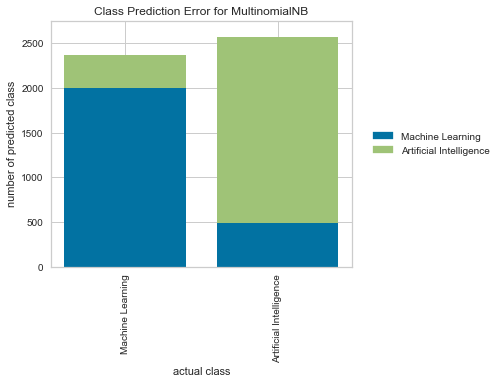

In [44]:
# Another take on the confusion matrix. Same findings as above
cpe = ClassPredictionError(nb, classes=['Machine Learning', 'Artificial Intelligence'])
cpe.fit(X_train, y_train)
cpe.score(X_test, y_test)
cpe.show(outpath='./assets/nb_cpe.png');

In [178]:
nb_coef_df = pd.DataFrame(nb.coef_.reshape(-1, 1), tvect.get_feature_names(), columns=['Coefficients'])

In [182]:
# Sorting words of highest importance.
nb_coef_df.sort_values(by='Coefficients', ascending=False).head(15)

,Coefficients
removed,-4.782653
learning,-5.358082
machine,-5.561061
model,-5.924003
data,-6.059799
ai,-6.126713
ml,-6.136285
http,-6.164383
using,-6.467586
project,-6.490504


## Naive-Bayes Pipeline and Grid Search

Below are 3 iterations of a Naive-Bayes grid search. I narrowed down a few hyperparameters of importance and included them in the model above for faster training.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [20]:
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [21]:
params = {
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'multinomialnb__alpha': [.01, .1, 1, 10, 100, 1000]
}

In [22]:
gs = GridSearchCV(pipe, params)

In [23]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1, 10, 100, 1000],
                         'tfidfvectorizer__ngram_range': [(1, 1), (2, 2),
                                                          (3, 3)],
                         'tfidfvectorizer__stop_words': [None, 'english']})

In [24]:
# Reviewing the grid search's best parameters. It performs better with a higher alpha
gs.best_params_

{'multinomialnb__alpha': 100,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english'}

In [25]:
gs.score(X_test, y_test)

0.8168557536466775

In [26]:
updated_params = {
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2)],
    'multinomialnb__alpha': [200, 250, 300, 350]
}

In [27]:
gs2 = GridSearchCV(pipe, updated_params)

In [28]:
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [200, 250, 300, 350],
                         'tfidfvectorizer__ngram_range': [(1, 1), (2, 2)],
                         'tfidfvectorizer__stop_words': ['english']})

In [29]:
gs2.best_params_

{'multinomialnb__alpha': 200,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english'}

In [30]:
gs2.score(X_test, y_test)

0.817868719611021

In [32]:
updated_params2 = {
    'tfidfvectorizer__stop_words': ['english', my_stop_words],
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2)],
    'multinomialnb__alpha': [1, 100, 200]
}

In [33]:
gs3 = GridSearchCV(pipe, updated_params2)

In [34]:
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [1, 100, 200],
                         'tfidfvectorizer__ngram_range': [(1, 1), (2, 2)],
                         'tfidfvectorizer__stop_words': ['english',
                                                         frozenset({'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                                                    'again',
                                                                    'against',
                 

In [35]:
gs3.best_params_

{'multinomialnb__alpha': 200,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english'}

In [36]:
gs3.score(X_test, y_test)

0.817868719611021